In [1]:
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python3)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

mkdir: build: File exists
-- The C compiler identification is AppleClang 11.0.3.11030032
-- The CXX compiler identification is AppleClang 11.0.3.11030032
-- Check for working C compiler: /Library/Developer/CommandLineTools/usr/bin/cc
-- Check for working C compiler: /Library/Developer/CommandLineTools/usr/bin/cc - works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /Library/Developer/CommandLineTools/usr/bin/c++
-- Check for working CXX compiler: /Library/Developer/CommandLineTools/usr/bin/c++ - works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found PythonInterp: /usr/local/bin/python3 (found version "3.7.7") 
-- Found PythonLibs: /usr/local/opt/python/Frameworks/Python.framework/Versions/3.7/lib/libpython3.7m.dylib
-- pybind11 v2.5

In [67]:
import math 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from mpl_toolkits import mplot3d
from sklearn.linear_model import LinearRegression

In [68]:
# Verifico la correcta instalación. Si no falla el import está OK
!pwd
!python --version
import metnum

/Users/mariano.benzo/Facultad/Metodos/TP3/metnum-tp3/notebooks
Python 2.7.16


## Linear Regression Predict

In [69]:
def linearRegressorPredict(df_train, df_test, cs, cPred):
    x = df_train[cs].values
    y = df_train[cPred].values
    x = x.reshape(len(x), x.shape[1])
    y = y.reshape(len(y), 1)

    linear_regressor = metnum.LinearRegression()
    linear_regressor.fit(x,y)

    x = df_test[cs].values
    x = x.reshape(len(x), x.shape[1])
    
    df_test[cPred] = linear_regressor.predict(x)
    
    df_test = df_test[df_test[cPred] < 0].dropna()


## K-Fold Cross-Validation

In [70]:
def splitTrainSet(x, y, K, i):
    size = int(x.shape[0] * 1/K)
    
    x_train1 = x[:i * size]
    x_train2 = x[(i + 1) * size:]
    x_train = np.concatenate((x_train1, x_train2))
    x_test = x[i * size:(i + 1) * size]
    
    y_train1 = y[:i * size]
    y_train2 = y[(i + 1) * size:]
    y_train = np.concatenate((y_train1, y_train2))
    y_test = y[i * size:(i + 1) * size]
    
    return x_train, y_train, x_test, y_test

In [71]:
from sklearn.linear_model import LinearRegression

def linearRegressionKFoldErrors(df_train, cs, cPred, K):
    
    x = df_train[cs].values
    y = df_train[cPred].values
    x = x.reshape(len(x), x.shape[1])
    y = y.reshape(len(y), 1)

    RMSE = []
    RMSLE = []
    average_error = []
    
    for i in range(0, K):
        x_train, y_train, x_test, y_test = splitTrainSet(x, y, K, i)
                
        linear_regressor = metnum.LinearRegression()

        linear_regressor.fit(x_train, y_train)
        
        y_pred = linear_regressor.predict(x_test)
        
        y_test, y_pred = deleteNegativeElements(y_test, y_pred)
            
        e = linearRegressorRMSE(y_test, y_pred)
        le = linearRegressorRMSLE(y_test, y_pred)
        avg_error = linearRegressorAverageError(y_test, y_pred)
        
        RMSE.append(e)
        RMSLE.append(le)
        average_error.append(avg_error)

    RMSE = np.mean(RMSE)
    RMSLE = np.mean(RMSLE)
    average_error = np.mean(average_error)

    return RMSE, RMSLE, average_error

In [72]:
def deleteNegativeElements(y_test, y_pred):
    negativeIndex = []
    for i in range(0, len(y_pred)):
        if (y_pred[i] < 0 or y_test[i] < 0):
            negativeIndex.append(i)

    y_pred = [i for j, i in enumerate(y_pred) if j not in negativeIndex]
    y_test = [i for j, i in enumerate(y_test) if j not in negativeIndex]
            
    return y_test, y_pred

## RMSE & RMSLE & Average Error

In [73]:
def linearRegressorRMSE(y_test, y_pred):
    n = len(y_test)
    return math.sqrt(sum([(y_test[i] - y_pred[i])**2 for i in range(0, n)]) / n)

In [74]:
def linearRegressorRMSLE(y_test, y_pred):
    n = len(y_test)    
    return math.sqrt(sum([(math.log(y_test[i] + 1) - (math.log(y_pred[i] + 1)))**2 for i in range(0, n)]) / n)

In [75]:
def linearRegressorAverageError(y_test, y_pred):
    n = len(y_test)
    avg = np.mean(y_test)
    avg_error = np.mean([abs(y_test[i] - y_pred[i]) for i in range(0, n)])
    
    return avg_error / avg

## Figures 2D & 3D

In [76]:
def linearRegressorFigure2D(df_train, df_test, c1, cPred):
    sns.scatterplot(data=df_train, x=c1, y=cPred)
    sns.lineplot(data=df_test, x=c1, y=cPred, color='red')

In [77]:
def linearRegressorFigure3D(df_train, df_test, c1, c2, cPred):
    fig = plt.figure()
    ax = plt.axes(projection='3d')

    xline = df_test[c1].values
    yline = df_test[c2].values
    zline = df_test[cPred].values
    ax.plot_trisurf(xline, yline, zline, color='red', alpha=0.5)

    xdata = df_train[c1].values
    ydata = df_train[c2].values
    zdata = df_train[cPred].values
    ax.scatter3D(xdata, ydata, zdata, edgecolors='blue')

    ax.set_xlabel(c1)
    ax.set_ylabel(c2)
    ax.set_zlabel(cPred)

## Experimentacion 1

### Metros totales

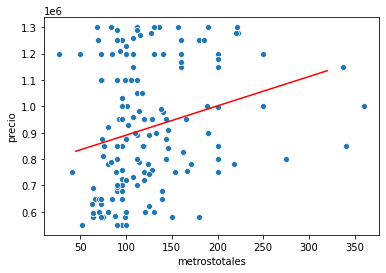

In [424]:
df_train = pd.read_csv('../data/train1.csv')

n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

linearRegressorPredict(df_train, df_test, ['metrostotales'], 'precio')
linearRegressorFigure2D(df_train, df_test, 'metrostotales', 'precio')

In [425]:
df_train = pd.read_csv('../data/train1.csv')
K = 5

RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['metrostotales'], 'precio', K)
print('RMSE: ', RMSE)
print('RMSLE: ', RMSLE)
print('Average Error: ', average_error)

RMSE:  228899.83500094712
RMSLE:  0.25610078937542036
Average Error:  0.21547686020579154


### Metros cubiertos

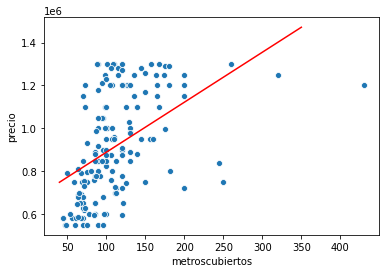

In [426]:
df_train = pd.read_csv('../data/train1.csv')

n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

linearRegressorPredict(df_train, df_test, ['metroscubiertos'], 'precio')
linearRegressorFigure2D(df_train, df_test, 'metroscubiertos', 'precio')

In [427]:
df_train = pd.read_csv('../data/train1.csv')
K = 5

RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['metrostotales', 'metroscubiertos'], 'precio', K)
print('RMSE: ', RMSE)
print('RMSLE: ', RMSLE)
print('Average Error: ', average_error)

RMSE:  217946.9173515772
RMSLE:  0.23851249001083435
Average Error:  0.1954297503983749


### Habitaciones

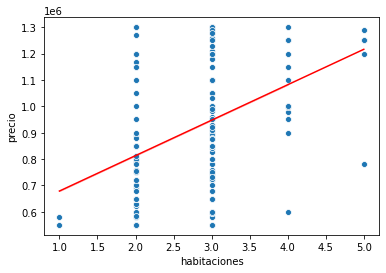

In [428]:
df_train = pd.read_csv('../data/train1.csv')

n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

linearRegressorPredict(df_train, df_test, ['habitaciones'], 'precio')
linearRegressorFigure2D(df_train, df_test, 'habitaciones', 'precio')

In [429]:
df_train = pd.read_csv('../data/train1.csv')
K = 5

RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['metrostotales', 'metroscubiertos', 'habitaciones'], 'precio', K)
print('RMSE: ', RMSE)
print('RMSLE: ', RMSLE)
print('Average Error: ', average_error)

RMSE:  210340.69496214623
RMSLE:  0.23084438391144912
Average Error:  0.1891289242358461


### Baños

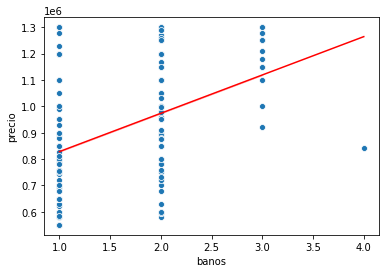

In [430]:
df_train = pd.read_csv('../data/train1.csv')

n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

linearRegressorPredict(df_train, df_test, ['banos'], 'precio')
linearRegressorFigure2D(df_train, df_test, 'banos', 'precio')

In [431]:
df_train = pd.read_csv('../data/train1.csv')
K = 5

RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['metrostotales', 'metroscubiertos', 'habitaciones', 'banos'], 'precio', K)
print('RMSE: ', RMSE)
print('RMSLE: ', RMSLE)
print('Average Error: ', average_error)

RMSE:  204500.7268577965
RMSLE:  0.2247963181533657
Average Error:  0.18121067882181724


### Garages

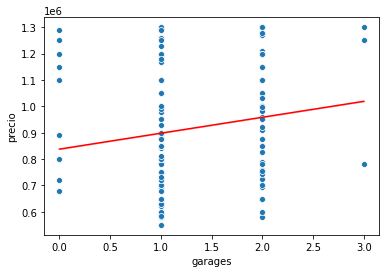

In [432]:
df_train = pd.read_csv('../data/train1.csv')

n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

linearRegressorPredict(df_train, df_test, ['garages'], 'precio')
linearRegressorFigure2D(df_train, df_test, 'garages', 'precio')

In [433]:
df_train = pd.read_csv('../data/train1.csv')
K = 5

RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['metrostotales', 'metroscubiertos', 'habitaciones', 'banos', 'garages'], 'precio', K)
print('RMSE: ', RMSE)
print('RMSLE: ', RMSLE)
print('Average Error: ', average_error)

RMSE:  205006.3239864386
RMSLE:  0.22518213043852095
Average Error:  0.18124846558431304


### Piscina

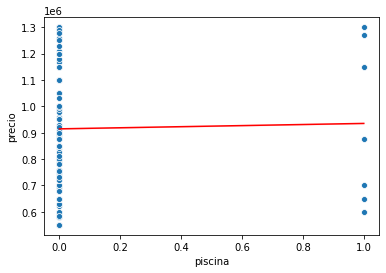

In [434]:
df_train = pd.read_csv('../data/train1.csv')

n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

linearRegressorPredict(df_train, df_test, ['piscina'], 'precio')
linearRegressorFigure2D(df_train, df_test, 'piscina', 'precio')

In [435]:
df_train = pd.read_csv('../data/train1.csv')
K = 5

RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['metrostotales', 'metroscubiertos', 'habitaciones', 'banos', 'garages', 'piscina'], 'precio', K)
print('RMSE: ', RMSE)
print('RMSLE: ', RMSLE)
print('Average Error: ', average_error)

RMSE:  207557.13275750048
RMSLE:  0.22792278365271973
Average Error:  0.18342419820837694


### Antigüedad

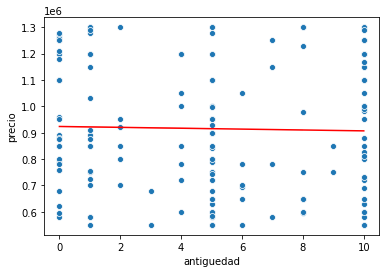

In [436]:
df_train = pd.read_csv('../data/train1.csv')

n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

linearRegressorPredict(df_train, df_test, ['antiguedad'], 'precio')
linearRegressorFigure2D(df_train, df_test, 'antiguedad', 'precio')

In [437]:
df_train = pd.read_csv('../data/train1.csv')
K = 5

RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['metrostotales', 'metroscubiertos', 'habitaciones', 'banos', 'garages', 'piscina', 'antiguedad'], 'precio', K)
print('RMSE: ', RMSE)
print('RMSLE: ', RMSLE)
print('Average Error: ', average_error)

RMSE:  207765.56743597024
RMSLE:  0.22843810502793707
Average Error:  0.1832884753701381


### Comodidades

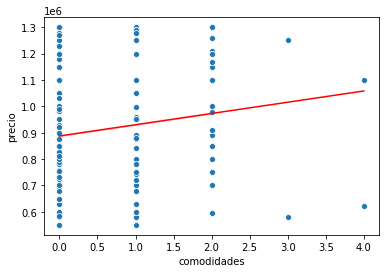

In [438]:
df_train = pd.read_csv('../data/train1.csv')

n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

linearRegressorPredict(df_train, df_test, ['comodidades'], 'precio')
linearRegressorFigure2D(df_train, df_test, 'comodidades', 'precio')

In [439]:
df_train = pd.read_csv('../data/train1.csv')
K = 5

RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['metrostotales', 'metroscubiertos', 'habitaciones', 'banos', 'garages', 'piscina', 'antiguedad', 'comodidades'], 'precio', K)
print('RMSE: ', RMSE)
print('RMSLE: ', RMSLE)
print('Average Error: ', average_error)

RMSE:  207921.94862176137
RMSLE:  0.22893790420089744
Average Error:  0.18251758656229375


### Densidad poblacional

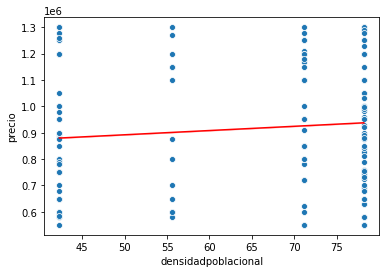

In [440]:
df_train = pd.read_csv('../data/train1.csv')

n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

linearRegressorPredict(df_train, df_test, ['densidadpoblacional'], 'precio')
linearRegressorFigure2D(df_train, df_test, 'densidadpoblacional', 'precio')

In [441]:
df_train = pd.read_csv('../data/train1.csv')
K = 5

RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['metrostotales', 'metroscubiertos', 'habitaciones', 'banos', 'garages', 'piscina', 'antiguedad', 'comodidades', 'densidadpoblacional'], 'precio', K)
print('RMSE: ', RMSE)
print('RMSLE: ', RMSLE)
print('Average Error: ', average_error)

RMSE:  207340.40722934375
RMSLE:  0.2283562884855793
Average Error:  0.18253958827984987


### Criminalidad

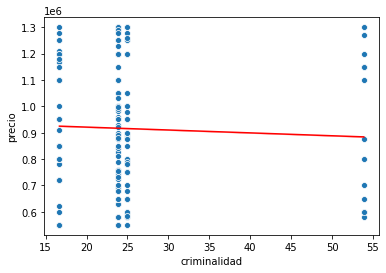

In [442]:
df_train = pd.read_csv('../data/train1.csv')

n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

linearRegressorPredict(df_train, df_test, ['criminalidad'], 'precio')
linearRegressorFigure2D(df_train, df_test, 'criminalidad', 'precio')

In [443]:
df_train = pd.read_csv('../data/train1.csv')
K = 5

RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['metrostotales', 'metroscubiertos', 'habitaciones', 'banos', 'garages', 'piscina', 'antiguedad', 'comodidades', 'criminalidad'], 'precio', K)
print('RMSE: ', RMSE)
print('RMSLE: ', RMSLE)
print('Average Error: ', average_error)

RMSE:  208355.2051832297
RMSLE:  0.2309941944415403
Average Error:  0.18189106727052695


### Mejor combinacion

In [444]:
df_train = pd.read_csv('../data/train1.csv')
K = 5

RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['metrostotales', 'metroscubiertos', 'habitaciones', 'banos', 'garages', 'piscina', 'antiguedad', 'comodidades'], 'precio', K)
print('RMSE: ', RMSE)
print('RMSLE: ', RMSLE)
print('Average Error: ', average_error)

RMSE:  207921.94862176137
RMSLE:  0.22893790420089744
Average Error:  0.18251758656229375


## Experimentacion 2

### Metros totales

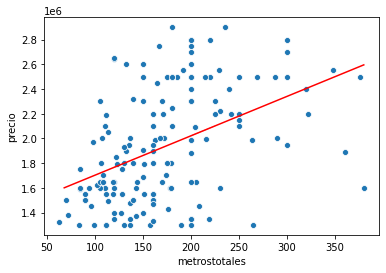

In [445]:
df_train = pd.read_csv('../data/train2.csv')

n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

linearRegressorPredict(df_train, df_test, ['metrostotales'], 'precio')
linearRegressorFigure2D(df_train, df_test, 'metrostotales', 'precio')

In [446]:
df_train = pd.read_csv('../data/train2.csv')
K = 5

RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['metrostotales'], 'precio', K)
print('RMSE: ', RMSE)
print('RMSLE: ', RMSLE)
print('Average Error: ', average_error)

RMSE:  401514.1920552633
RMSLE:  0.20796612226636335
Average Error:  0.17271724866814103


### Metros cubiertos

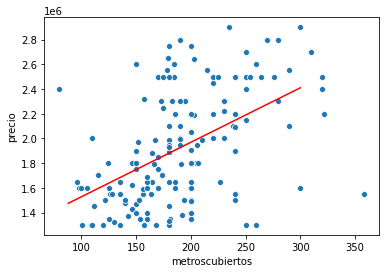

In [447]:
df_train = pd.read_csv('../data/train2.csv')

n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

linearRegressorPredict(df_train, df_test, ['metroscubiertos'], 'precio')
linearRegressorFigure2D(df_train, df_test, 'metroscubiertos', 'precio')

In [448]:
df_train = pd.read_csv('../data/train2.csv')
K = 5

RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['metrostotales', 'metroscubiertos'], 'precio', K)
print('RMSE: ', RMSE)
print('RMSLE: ', RMSLE)
print('Average Error: ', average_error)

RMSE:  375936.127169922
RMSLE:  0.1954391299621074
Average Error:  0.1600460658504868


### Habitaciones

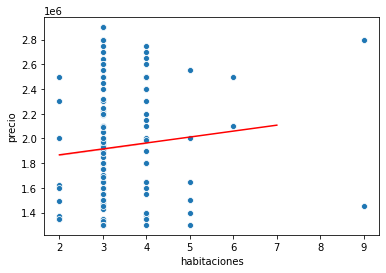

In [449]:
df_train = pd.read_csv('../data/train2.csv')

n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

linearRegressorPredict(df_train, df_test, ['habitaciones'], 'precio')
linearRegressorFigure2D(df_train, df_test, 'habitaciones', 'precio')

In [450]:
df_train = pd.read_csv('../data/train2.csv')
K = 5

RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['metrostotales', 'metroscubiertos', 'habitaciones'], 'precio', K)
print('RMSE: ', RMSE)
print('RMSLE: ', RMSLE)
print('Average Error: ', average_error)

RMSE:  377865.409754458
RMSLE:  0.19608604028151436
Average Error:  0.15976858703031513


### Baños

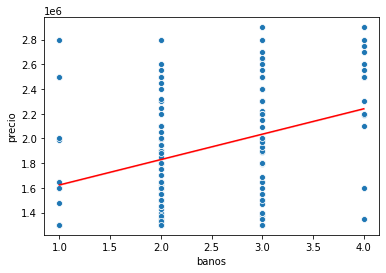

In [451]:
df_train = pd.read_csv('../data/train2.csv')

n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

linearRegressorPredict(df_train, df_test, ['banos'], 'precio')
linearRegressorFigure2D(df_train, df_test, 'banos', 'precio')

In [452]:
df_train = pd.read_csv('../data/train2.csv')
K = 5

RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['metrostotales', 'metroscubiertos', 'habitaciones', 'banos'], 'precio', K)
print('RMSE: ', RMSE)
print('RMSLE: ', RMSLE)
print('Average Error: ', average_error)

RMSE:  373514.3295274171
RMSLE:  0.19557640435933146
Average Error:  0.1558409628420901


### Garages

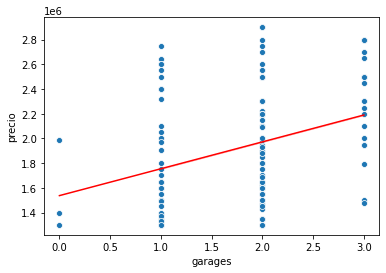

In [453]:
df_train = pd.read_csv('../data/train2.csv')

n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

linearRegressorPredict(df_train, df_test, ['garages'], 'precio')
linearRegressorFigure2D(df_train, df_test, 'garages', 'precio')

In [454]:
df_train = pd.read_csv('../data/train2.csv')
K = 5

RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['metrostotales', 'metroscubiertos', 'habitaciones', 'banos', 'garages'], 'precio', K)
print('RMSE: ', RMSE)
print('RMSLE: ', RMSLE)
print('Average Error: ', average_error)

RMSE:  366975.8709193074
RMSLE:  0.1926182136240325
Average Error:  0.1534292564130217


### Piscina

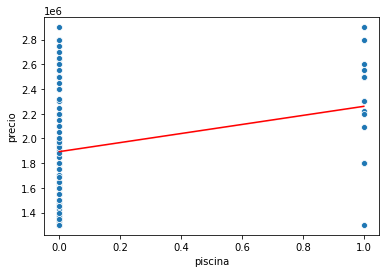

In [455]:
df_train = pd.read_csv('../data/train2.csv')

n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

linearRegressorPredict(df_train, df_test, ['piscina'], 'precio')
linearRegressorFigure2D(df_train, df_test, 'piscina', 'precio')

In [456]:
df_train = pd.read_csv('../data/train2.csv')
K = 5

RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['metrostotales', 'metroscubiertos', 'habitaciones', 'banos', 'garages', 'piscina'], 'precio', K)
print('RMSE: ', RMSE)
print('RMSLE: ', RMSLE)
print('Average Error: ', average_error)

RMSE:  366615.4418963776
RMSLE:  0.19222805913912072
Average Error:  0.15467262297731224


### Antigüedad

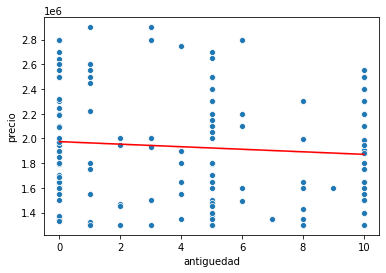

In [457]:
df_train = pd.read_csv('../data/train2.csv')

n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

linearRegressorPredict(df_train, df_test, ['antiguedad'], 'precio')
linearRegressorFigure2D(df_train, df_test, 'antiguedad', 'precio')

In [458]:
df_train = pd.read_csv('../data/train2.csv')
K = 5

RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['metrostotales', 'metroscubiertos', 'habitaciones', 'banos', 'garages', 'piscina', 'antiguedad'], 'precio', K)
print('RMSE: ', RMSE)
print('RMSLE: ', RMSLE)
print('Average Error: ', average_error)

RMSE:  362230.2107294626
RMSLE:  0.19049764705683642
Average Error:  0.1542539706601022


### Comodidades

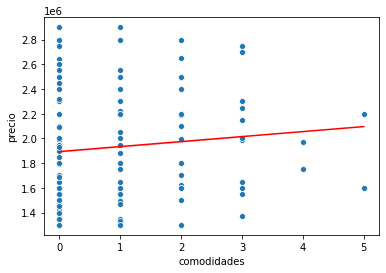

In [459]:
df_train = pd.read_csv('../data/train2.csv')

n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

linearRegressorPredict(df_train, df_test, ['comodidades'], 'precio')
linearRegressorFigure2D(df_train, df_test, 'comodidades', 'precio')

In [460]:
df_train = pd.read_csv('../data/train2.csv')
K = 5

RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['metrostotales', 'metroscubiertos', 'habitaciones', 'banos', 'garages', 'piscina', 'antiguedad', 'comodidades'], 'precio', K)
print('RMSE: ', RMSE)
print('RMSLE: ', RMSLE)
print('Average Error: ', average_error)

RMSE:  364440.48669535015
RMSLE:  0.19162772602795747
Average Error:  0.15556055335410562


### Densidad poblacional

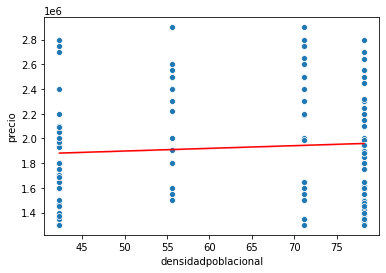

In [461]:
df_train = pd.read_csv('../data/train2.csv')

n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

linearRegressorPredict(df_train, df_test, ['densidadpoblacional'], 'precio')
linearRegressorFigure2D(df_train, df_test, 'densidadpoblacional', 'precio')

In [462]:
df_train = pd.read_csv('../data/train2.csv')
K = 5

RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['metrostotales', 'metroscubiertos', 'habitaciones', 'banos', 'garages', 'piscina', 'antiguedad', 'comodidades', 'densidadpoblacional'], 'precio', K)
print('RMSE: ', RMSE)
print('RMSLE: ', RMSLE)
print('Average Error: ', average_error)

RMSE:  362891.1409373541
RMSLE:  0.1906102216205459
Average Error:  0.15469743192464785


### Criminalidad

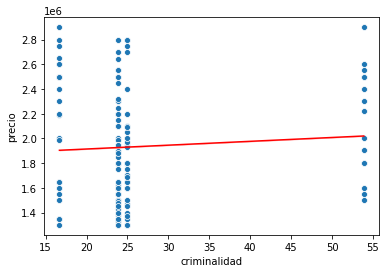

In [463]:
df_train = pd.read_csv('../data/train2.csv')

n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

linearRegressorPredict(df_train, df_test, ['criminalidad'], 'precio')
linearRegressorFigure2D(df_train, df_test, 'criminalidad', 'precio')

In [464]:
df_train = pd.read_csv('../data/train2.csv')
K = 5

RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['metrostotales', 'metroscubiertos', 'habitaciones', 'banos', 'garages', 'piscina', 'antiguedad', 'comodidades', 'criminalidad'], 'precio', K)
print('RMSE: ', RMSE)
print('RMSLE: ', RMSLE)
print('Average Error: ', average_error)

RMSE:  366755.3954866049
RMSLE:  0.1927853637767778
Average Error:  0.15575923692304508


### Mejor combinacion

In [465]:
df_train = pd.read_csv('../data/train2.csv')
K = 5

RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['metrostotales', 'metroscubiertos', 'habitaciones', 'banos', 'garages', 'piscina', 'antiguedad', 'comodidades'], 'precio', K)
print('RMSE: ', RMSE)
print('RMSLE: ', RMSLE)
print('Average Error: ', average_error)

RMSE:  364440.48669535015
RMSLE:  0.19162772602795747
Average Error:  0.15556055335410562
